In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics, model_selection 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibrationDisplay
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

In [3]:
#code to read the data into one dataframe
df = pd.DataFrame()
for i in range(5):
    df_temp = pd.read_csv(f'../data/processed_chinese_mnist_part_{i}.csv')
    df = df.append(df_temp)
df = df.reset_index(drop = True)

In [4]:
df.cn_label.value_counts()

零    1000
九    1000
十    1000
百    1000
千    1000
万    1000
亿    1000
一    1000
二    1000
三    1000
四    1000
五    1000
六    1000
七    1000
八    1000
Name: cn_label, dtype: int64

In [ ]:
X, y = df.iloc[:,3:], df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2)

In [ ]:
def calc_acc(preds, actual):
    tf_vals = pd.Series(preds) == pd.Series(actual)
    return sum(tf_vals)/len(tf_vals)

## ADABoost

In [19]:
# Tuning, report a basic performance of 0.2233
score_lists = []
n_est_candidates = [50, 100, 200, 300]
rate_candidates = [0.01, 0.1, 0.5, 1]
for test_n_est in n_est_candidates:
    for test_lr in rate_candidates:
        ada_mdl = AdaBoostClassifier(
        base_estimator = RandomForestClassifier(),
        n_estimators = test_n_est,
        learning_rate = test_lr
        )
        ada_mdl.fit(X_train, y_train)
        score_lists.append((ada_mdl.score(X_test, y_test), test_n_est, test_lr))
score_lists

[(1.0, 50, 0.01),
 (1.0, 50, 0.1),
 (1.0, 50, 0.5),
 (1.0, 50, 1),
 (1.0, 100, 0.01),
 (1.0, 100, 0.1),
 (1.0, 100, 0.5),
 (1.0, 100, 1),
 (1.0, 200, 0.01),
 (1.0, 200, 0.1),
 (1.0, 200, 0.5),
 (1.0, 200, 1),
 (1.0, 300, 0.01),
 (1.0, 300, 0.1),
 (1.0, 300, 0.5),
 (1.0, 300, 1)]

In [20]:
# Pick the hypertuned parameters and push into test set to see its performance
score_lists.sort(reverse = True)
ada_n_estimators = score_lists[0][1]
ada_lr = score_lists[0][2]
ada_mdl = AdaBoostClassifier(
    base_estimator = RandomForestClassifier(),
    n_estimators = ada_n_estimators,
    learning_rate = ada_lr
)
ada_mdl.fit(X_train, y_train)
ada_mdl.score(X_test, y_test)

0.5733333333333334

## XGBoost

In [80]:
xgb_mdl = xgb.XGBClassifier(
    max_depth = 12,
    learning_rate = 0.05
)
xgb_mdl.fit(X_train, y_train)
xgb_mdl.score(X_test, y_test)

C:\Users\liuhn\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:53:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6276666666666667

## LightGBM

In [81]:
# Reports an initial accuracy score of 0.718
lgb_scores = []
for n in [31, 41, 61, 81, 101, 111]:
    lgb_mdl = lgb.LGBMClassifier(
        learning_rate = 0.05,
        max_depth = 12,
        num_leaves = n
    )
    lgb_mdl.fit(X_train, y_train)
    lgb_scores.append((lgb_mdl.score(X_test, y_test), n))

In [83]:
# Pick the hypertuned parameters and push into test set to see its performance
lgb_scores.sort(reverse = True)
num_leaves = lgb_scores[0][1]
lgb_mdl = lgb.LGBMClassifier(
    max_depth = 12,
    num_leaves = num_leaves
)
lgb_mdl.fit(X_train, y_train)
lgb_mdl.score(X_test, y_test)

0.7186666666666667

## MLP

In [44]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [73]:
num_iter = 50
learning_rate = 0.01
batch_size = 64

In [64]:
def read_data(df_X, df_y):
    imgs = torch.tensor(df_X.to_numpy()).float()
    labels = torch.tensor(df_y.to_numpy()).long()
    dataset = utils.TensorDataset(imgs,labels)
    dataloader = utils.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [65]:
# accuracy calculation
def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [76]:
def trainMLP(train_loader,val_loader):
    # average training loss, one value per iteration (averaged over all batches in one iteration)
    avg_train_loss = []
    # average validation loss, one value per iteration (averaged over all batches in one iteration)
    avg_val_loss = []
    # record the lowest validation loss, used to determine early stopping (best model)
    best_val_score = float('inf')
    net = BaselineMLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    # for each iteration, iteratively train all batches
    net = net.train()
    i = 0
    while i < num_iter:
        train_running_loss = 0.0
        train_acc = 0.0
        for k, (images, labels) in enumerate(train_loader):
            logits = net(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            
            train_running_loss += loss.detach().item()
            train_acc += get_accuracy(logits, labels, batch_size)
        
        val_loss = 0
        for n, (val_images, val_labels) in enumerate(val_loader):
            logits = net(val_images)
            loss_temp = criterion(logits, val_labels)
#             loss_temp.backward()
#             optimizer.zero_grad()
            val_loss += loss_temp.detach().item()
            
        avg_train_loss.append(train_running_loss/k)
        avg_val_loss.append((evaluate(val_loader, net), net, val_loss/n))
        i+=1
        
        net.eval()
        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(i, train_running_loss / k, train_acc/k))
    net = avg_val_loss[-1][1]
    avg_val_loss = [ls for evaluation, net, ls in avg_val_loss]
    
    return net, avg_train_loss, avg_val_loss

In [77]:
# Model Evaluation
def evaluate(loader, net):
    total = 0
    correct = 0
    # use model to get predictions
    for X, y in loader:
        outputs = net(X)
        predictions = torch.argmax(outputs.data, 1)
        
        # total number of items in dataset
        total += y.shape[0]

        # number of correctly labeled items in dataset
        correct += torch.sum(predictions == y)

    # return fraction of correctly labeled items in dataset
    return float(correct) / float(total)

In [78]:
# Actual training process
train_loader = read_data(X_train, y_train)
test_loader = read_data(X_test, y_test)
net, t_losses, v_losses = trainMLP(train_loader,test_loader)
accuracy = evaluate(test_loader, net)
print("Test accuracy: {}".format(accuracy))

Epoch: 1 | Loss: 2.4417 | Train Accuracy: 22.83
Epoch: 2 | Loss: 1.9543 | Train Accuracy: 38.54
Epoch: 3 | Loss: 1.7182 | Train Accuracy: 46.22
Epoch: 4 | Loss: 1.5700 | Train Accuracy: 50.79
Epoch: 5 | Loss: 1.4655 | Train Accuracy: 53.85
Epoch: 6 | Loss: 1.3860 | Train Accuracy: 56.02
Epoch: 7 | Loss: 1.3231 | Train Accuracy: 57.89
Epoch: 8 | Loss: 1.2696 | Train Accuracy: 59.86
Epoch: 9 | Loss: 1.2237 | Train Accuracy: 61.33
Epoch: 10 | Loss: 1.1865 | Train Accuracy: 62.54
Epoch: 11 | Loss: 1.1515 | Train Accuracy: 63.60
Epoch: 12 | Loss: 1.1201 | Train Accuracy: 64.41
Epoch: 13 | Loss: 1.0905 | Train Accuracy: 65.32
Epoch: 14 | Loss: 1.0642 | Train Accuracy: 66.48
Epoch: 15 | Loss: 1.0431 | Train Accuracy: 66.79
Epoch: 16 | Loss: 1.0204 | Train Accuracy: 67.84
Epoch: 17 | Loss: 0.9984 | Train Accuracy: 68.52
Epoch: 18 | Loss: 0.9814 | Train Accuracy: 68.87
Epoch: 19 | Loss: 0.9622 | Train Accuracy: 69.42
Epoch: 20 | Loss: 0.9454 | Train Accuracy: 70.24
Epoch: 21 | Loss: 0.9292 | Tr

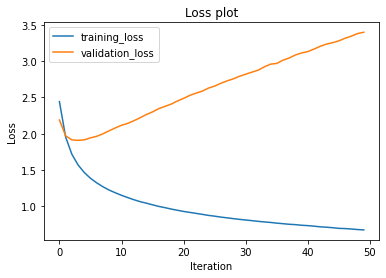

In [79]:
# Loss plot
plt.plot(t_losses)
plt.plot(v_losses)
plt.legend(["training_loss","validation_loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss plot")
plt.show()

In [69]:
# PyTorch and neural network imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
import numpy as np

# set the randomness to keep reproducible results
torch.manual_seed(0)
np.random.seed(0)

dummy = 1
# input size to your mlp network
mlp_input_size = 4096 # TODO1
# final output size of your mlp network (output layer)
mlp_output_size = 16 # TODO2
# TODO3: you may need to experiment a bit (width of your hidden layer)
mlp_hidden_size = 10

class BaselineMLP(nn.Module):
    def __init__(self):
        """
        A multilayer perceptron model
        Consists of one hidden layer and 1 output layer (all fully connected)
        """
        super(BaselineMLP, self).__init__()
        # a fully connected layer from input layer to hidden layer
        # mlp_input_size denotes how many input neurons you have
        # mlp_hiddent_size denotes how many hidden neurons you have
        self.fc1 = nn.Linear(mlp_input_size, mlp_hidden_size)
        # a fully connected layer from hidden layer to output layer
        # mlp_output_size denotes how many output neurons you have
        self.fc2 = nn.Linear(mlp_hidden_size, mlp_output_size)
    
    def forward(self, X):
        """
        Pass the batch of images through each layer of the network, applying 
        logistic activation function after hidden layer.
        """
        # pass X from input layer to hidden layer
        out = self.fc1(X)
        # apply an activation function to the output of hidden layer
        out = torch.sigmoid(out)
        # pass output from hidden layer to output layer
        out = self.fc2(out)
        # return the feed forward output
        # you don't need to apply another activation function here if
        # the loss function you use already implement it for you
        return out